In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter3_"

loss_list = []
normalized_loss_list = []

print(datetime.datetime.now())

2023-06-26 01:13:28.544280


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae2_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae2_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter2")

dec: h_dim 64
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter2 ckpt_iwvi_pendulum_policy_optimization_iter2
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter2
base load self.initial_belief.data.sum() tensor(1.6121)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-6.2741)
penalty_target_min tensor(-6.1621) penalty_target_max tensor(76.8819)
train_loss:  -5.629574252319336
valid_loss:  -4.600165733337402
h_min_tilde -6.162122 ell_tilde -5.42369254852295 kappa_tilde 0.0011637121319375962
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter2
train_loss:  -1.226410896551609
valid_loss:  -1.4648620764017104
weight_alpha 1.0 h_min_tilde -6.162122 ell_tilde -1.2741011325216294 kappa_tilde 0.0004523071826941878


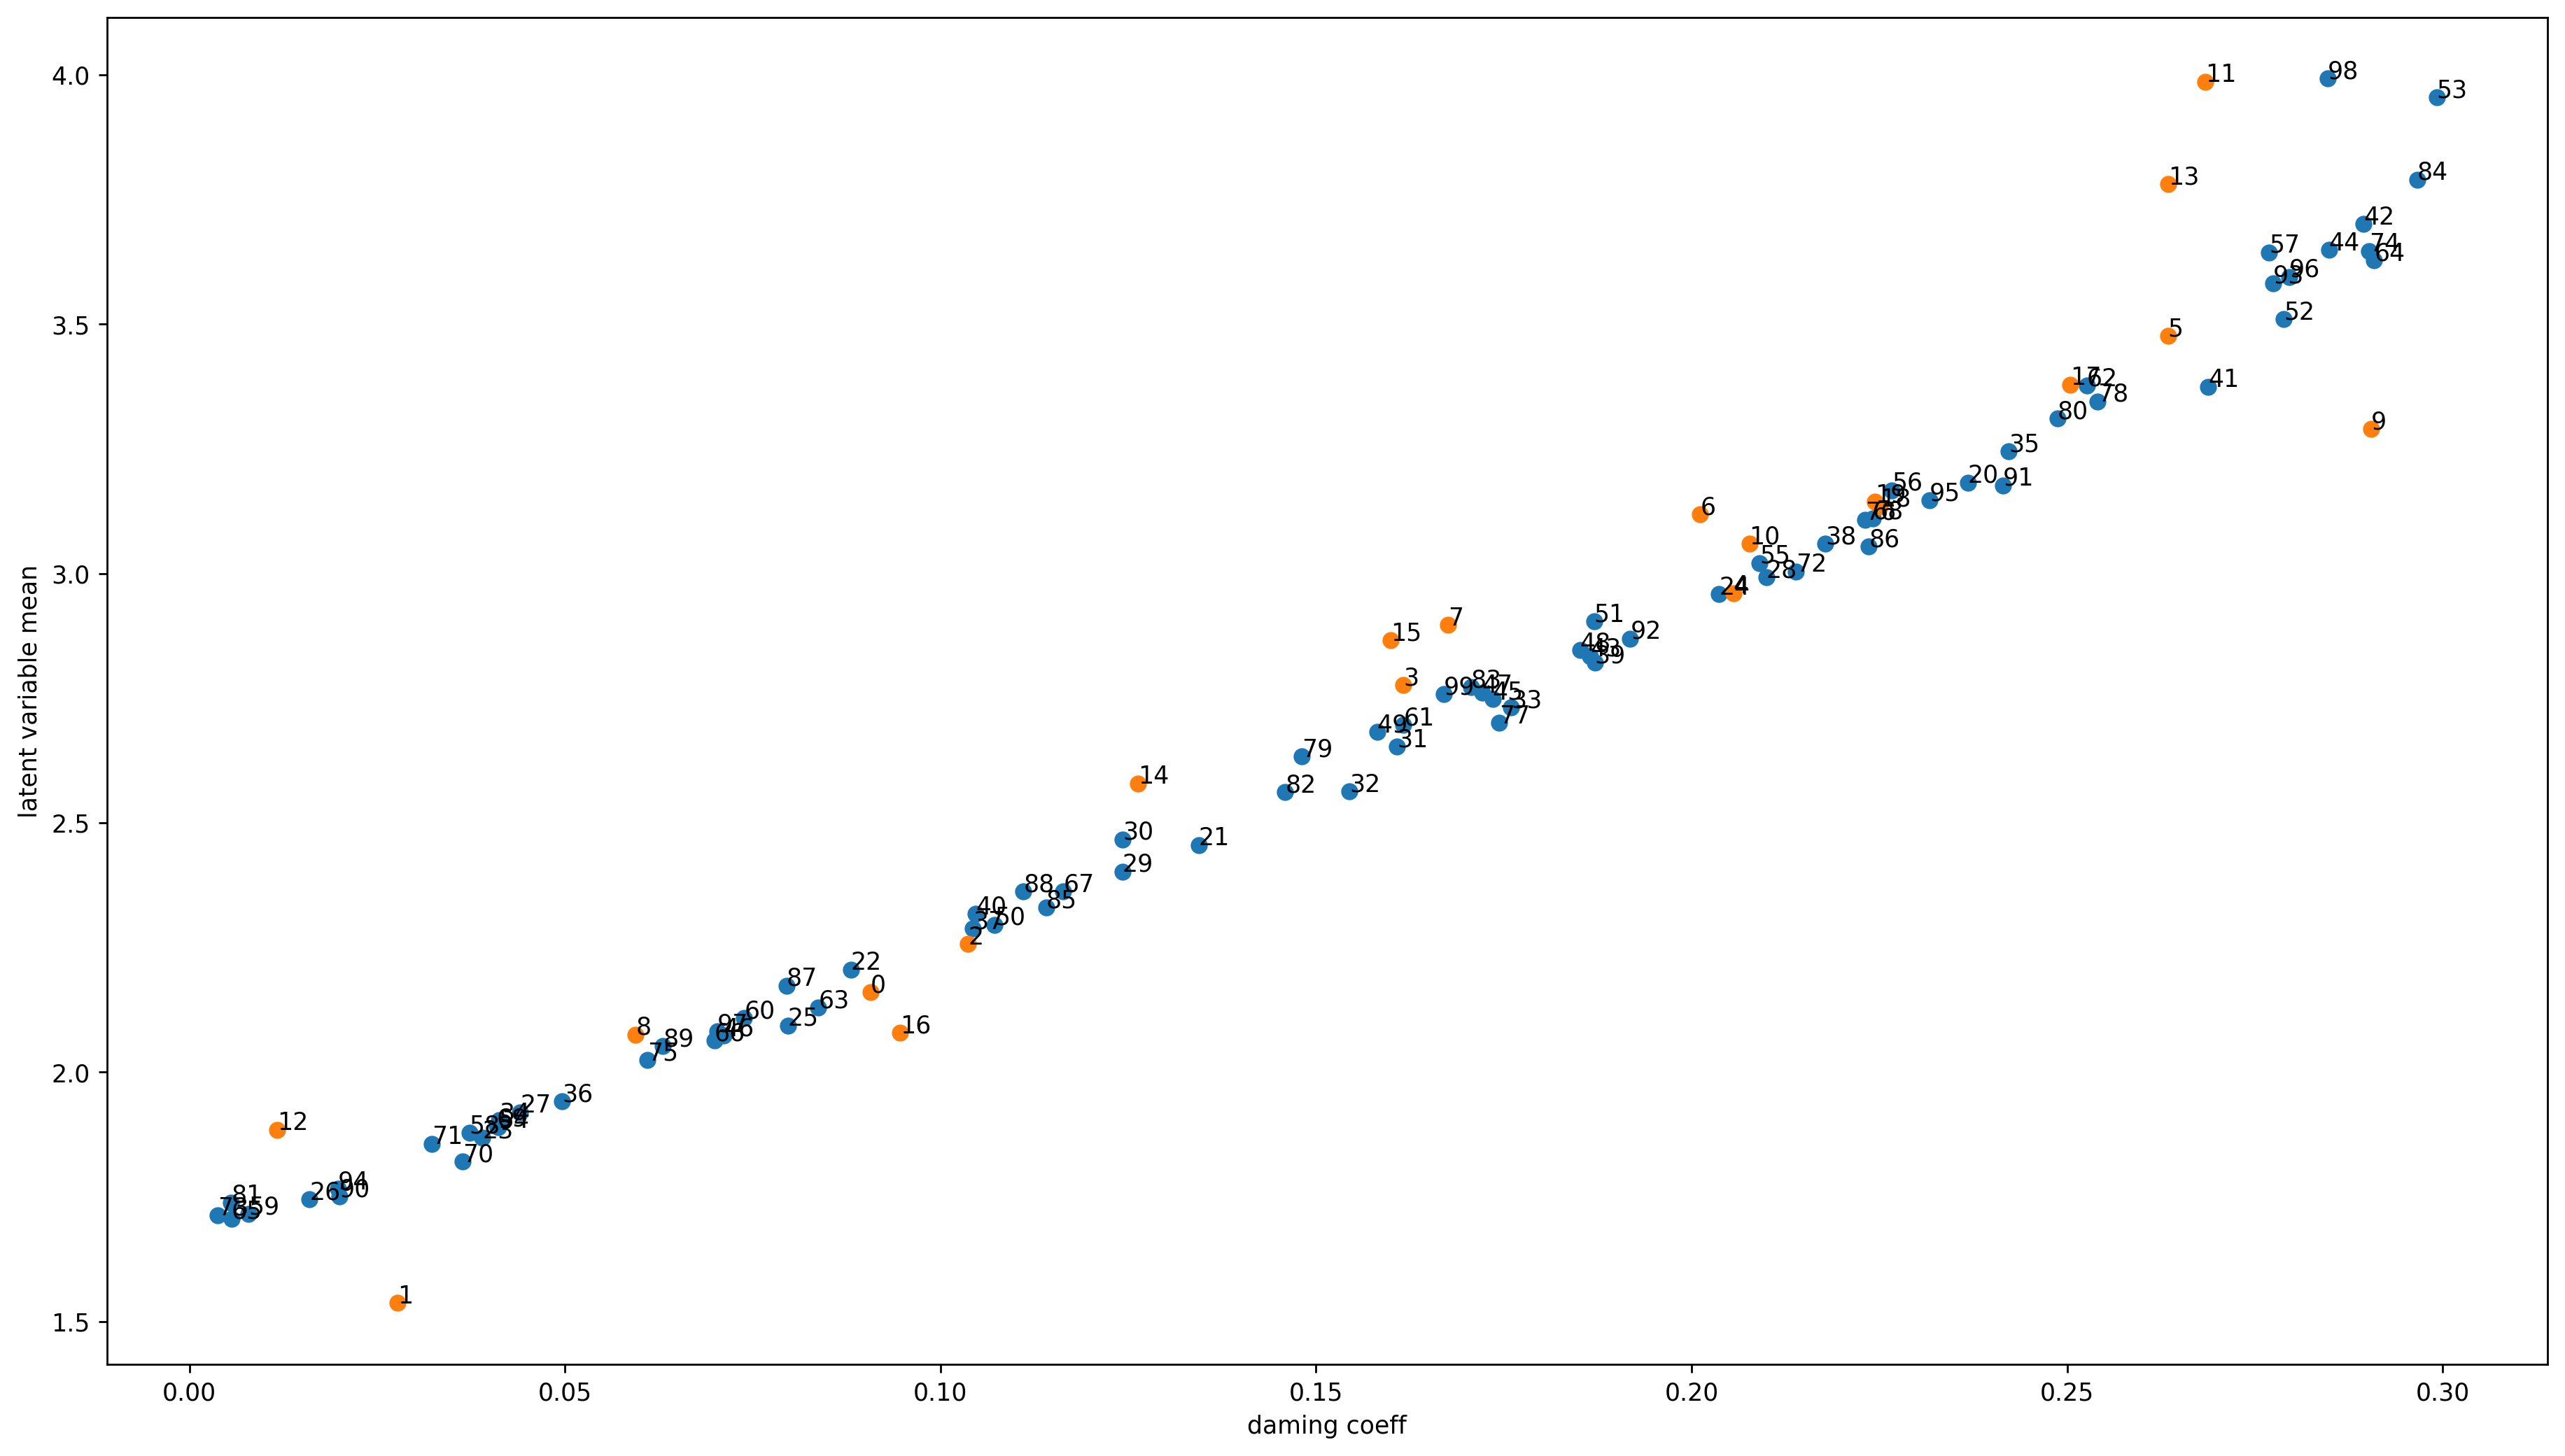

[0.09069977 0.02770158 0.10366822 0.16164502 0.20556585 0.26343523
 0.20114025 0.16760695 0.05943045 0.29047847]
[0.20769678 0.268382   0.01171643 0.26344275 0.12633229 0.15994959
 0.09465469 0.2503877  0.22504329 0.2244497 ]
[0.2367838  0.13436806 0.08808424 0.03900857 0.20365066 0.079664
 0.01600876 0.04401857 0.20992751 0.1242168 ]
[0.12425378 0.16076892 0.15446673 0.17596651 0.04124241 0.24221739
 0.04960626 0.10432976 0.2177994  0.18710166]
[0.1046695  0.26876587 0.28945201 0.18650872 0.28484678 0.17351688
 0.07110809 0.17210385 0.18514347 0.15811743]
[0.10718093 0.18700803 0.27883117 0.29919686 0.04114072 0.20904545
 0.22663892 0.27690736 0.03728129 0.0078633 ]
[0.07386332 0.16164932 0.25260927 0.0837551  0.29087872 0.00559419
 0.06989228 0.11635819 0.22413649 0.04093657]
[0.03640304 0.03224824 0.21389669 0.00376679 0.2901829  0.06098797
 0.22314776 0.17440768 0.25404864 0.14813091]
[0.24869427 0.00557286 0.14590353 0.17065543 0.29658485 0.11404235
 0.22360033 0.07947587 0.111025

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 7.152557373046875e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 3.9125823974609375

 2 3.908684492111206

 3 4.0421624183654785

 4 3.805549383163452

 5 3.9232125282287598

 6 3.8643698692321777

 7 3.7458908557891846

 8 3.789435863494873

 9 3.837223768234253

 10 3.962090253829956

 11 3.565209150314331

 12 3.7989437580108643

 13 3.832376718521118

 14 3.7353501319885254

 15 3.7178590297698975

 16 3.5062408447265625

 17 3.808314323425293

 18 3.8543734550476074

 19 3.8082706928253174

 20 3.751204252243042

 21 3.609071731567383

 22 3.6360723972320557

 23 3.834179639816284

 24 3.732633590698242

 25 3.643982172012329

 26 3.7403159141540527

 27 3.6640241146087646

 28 3.6915621757507324

 29 3.588047504425049

 30 3.6861066818237305

 31 3.572911262512207

 32 3.5894834995269775

 33 3.6968190670013428

 34 3.6741113662719727

 35 3.6452348232269287

 36 3.610910177230835

 37 3.575369119644165

 38 3.7224936485290527

 39 3.78643536567688

 40 3.586090564727783

 41 3.890963554382324

 42 3.526136875152588

 43 3.710519790649414


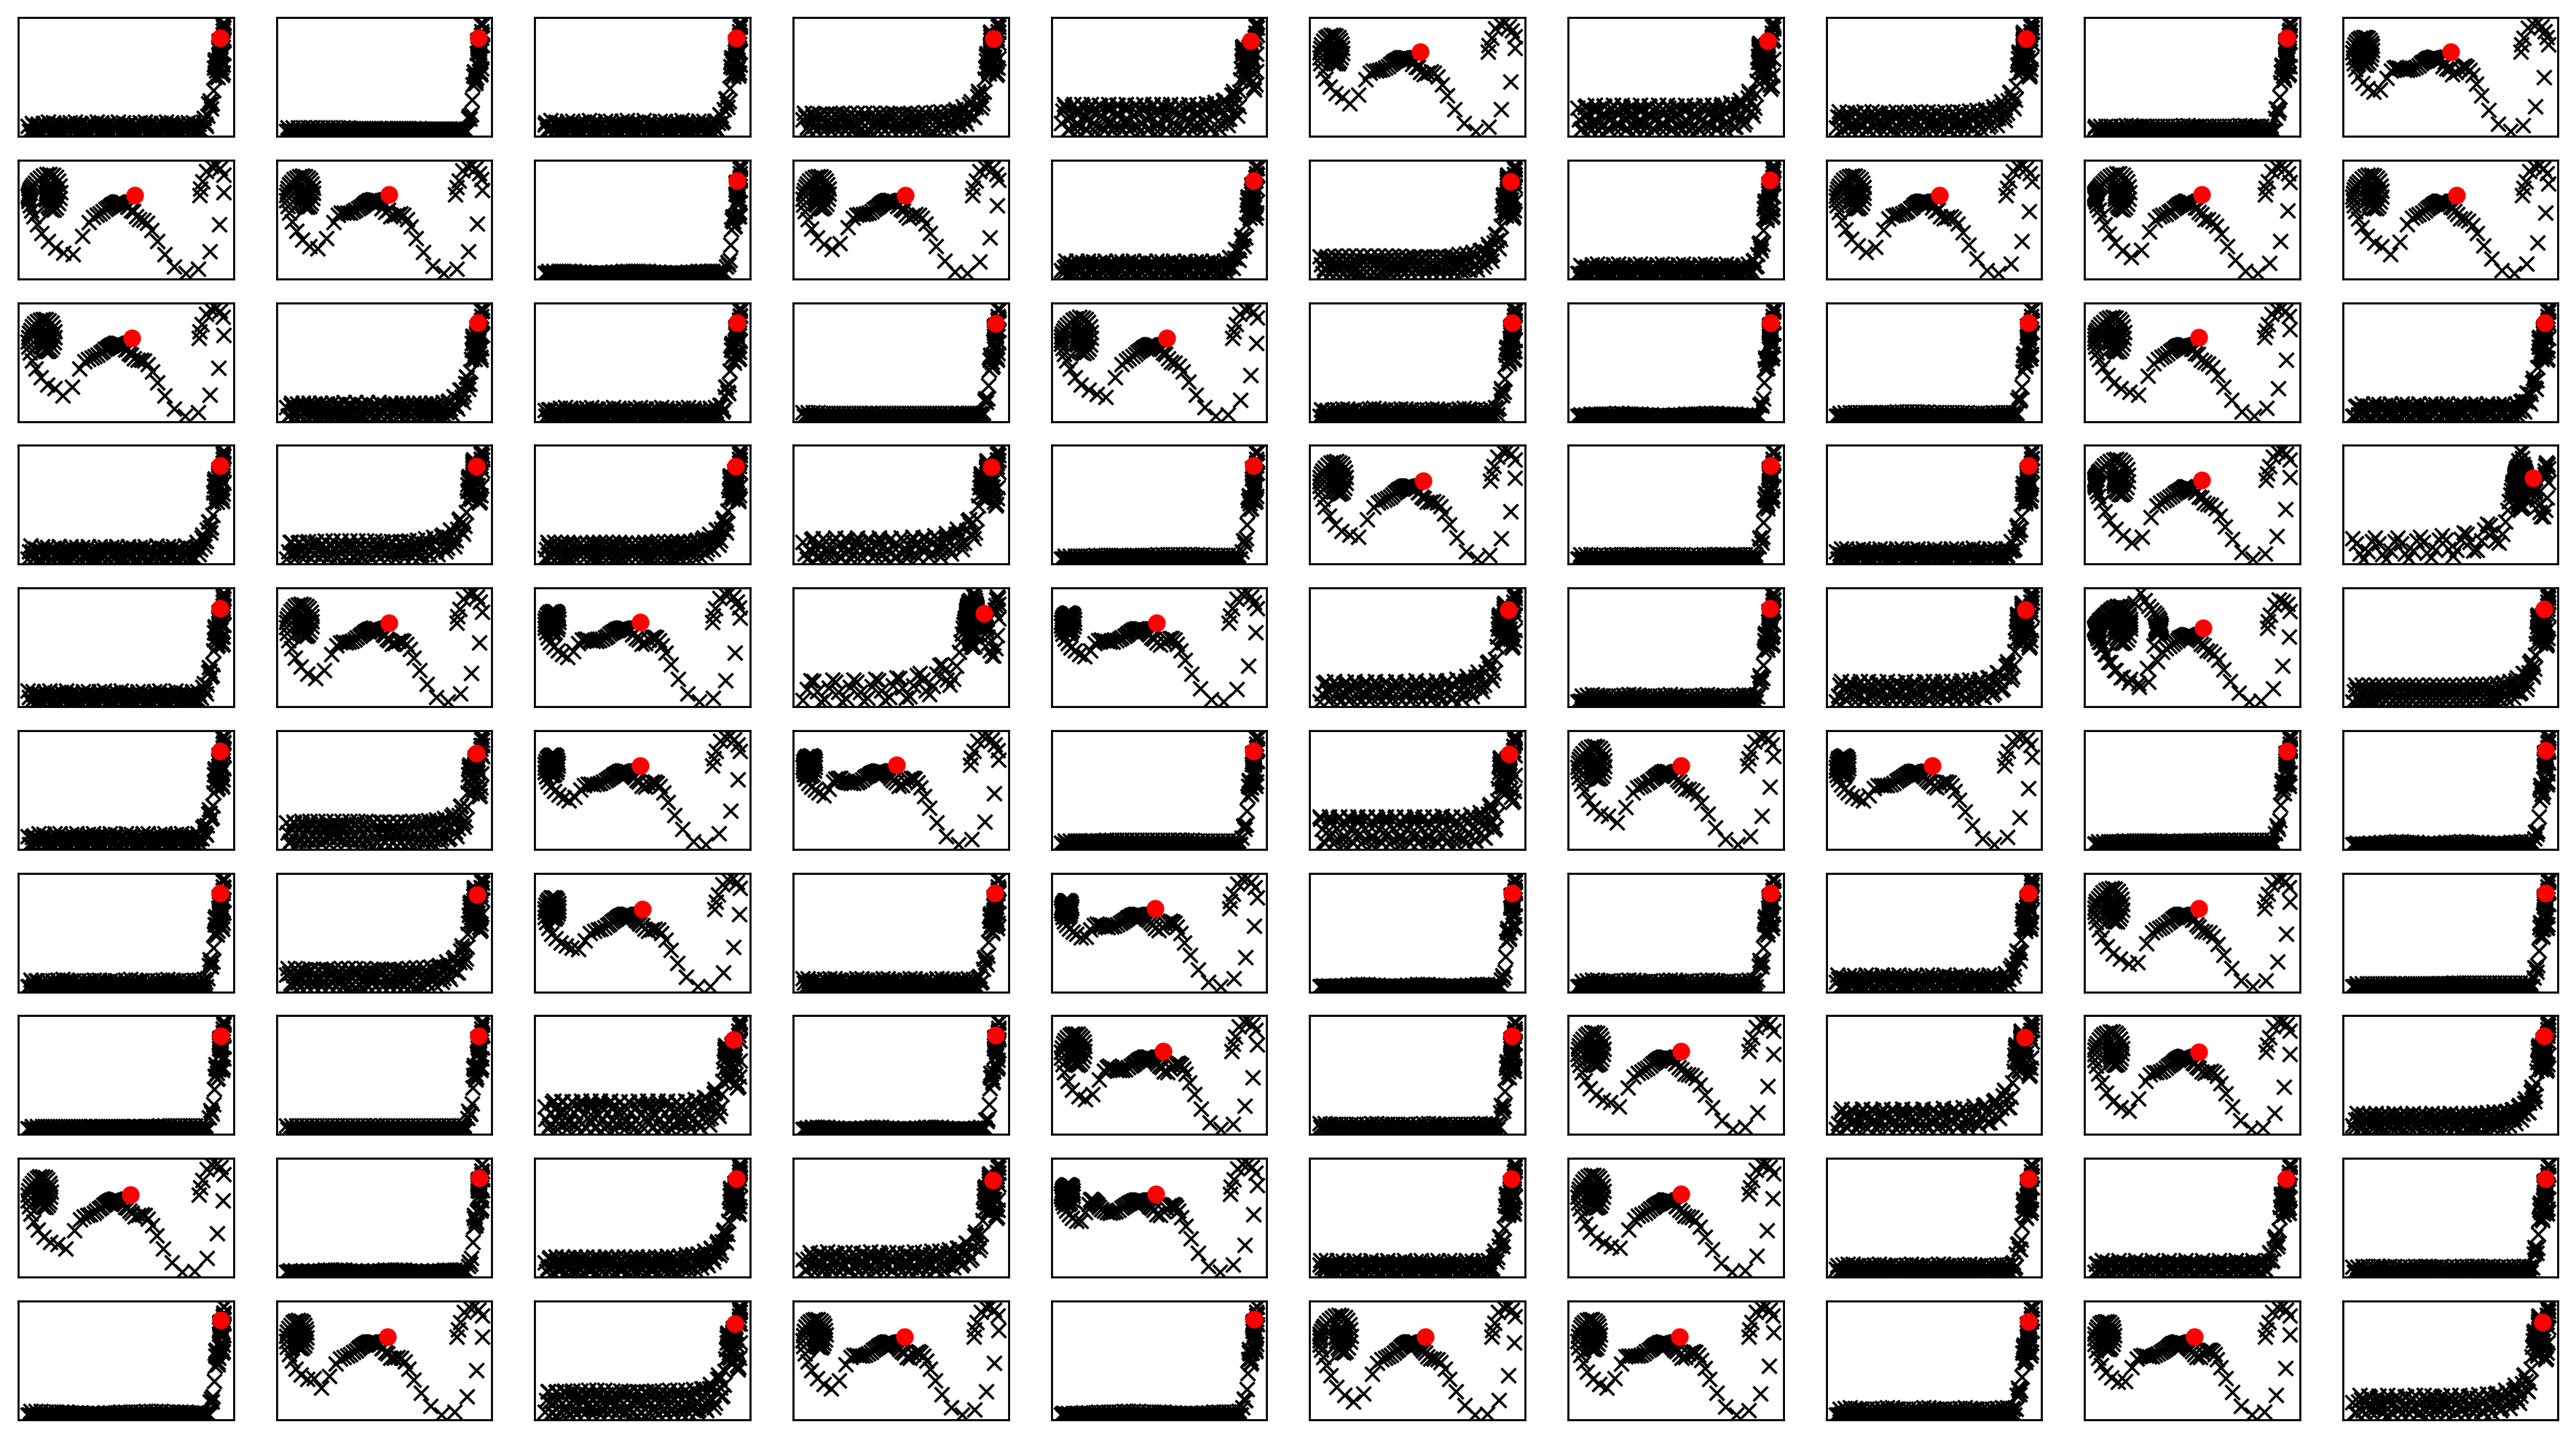

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [8]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 4.76837158203125e-07

 1 4.040386199951172

 2 3.688094139099121

 3 3.5767736434936523

 4 3.71337628364563

 5 3.7426888942718506

 6 3.728428363800049

 7 4.895326852798462

 8 7.588491439819336

 9 7.827056646347046

 10 4.894652605056763

 11 3.7287003993988037

 12 3.6697678565979004

 13 3.5761544704437256

 14 3.8023576736450195

 15 3.539818286895752

 16 3.4521713256835938

 17 3.5434792041778564

 18 3.6972157955169678

 19 3.765937328338623

 20 3.57000994682312

 21 3.600404977798462

 22 3.6290011405944824

 23 3.5742311477661133

 24 3.6019022464752197

 25 3.5745582580566406

 26 3.673431158065796

 27 3.55491042137146

 28 3.5918095111846924

 29 3.7473673820495605

 30 3.6107547283172607

 31 3.5598089694976807

 32 3.580080032348633

 33 3.7620139122009277

 34 3.658827304840088

 35 3.6234757900238037

 36 3.7003257274627686

 37 3.498051643371582

 38 3.5778160095214844

 39 3.523560047149658

 40 3.776611089706421

 41 3.5741899013519287

 42 3.897200345993042

実環境方策rollout vs Sim環境方策rollout


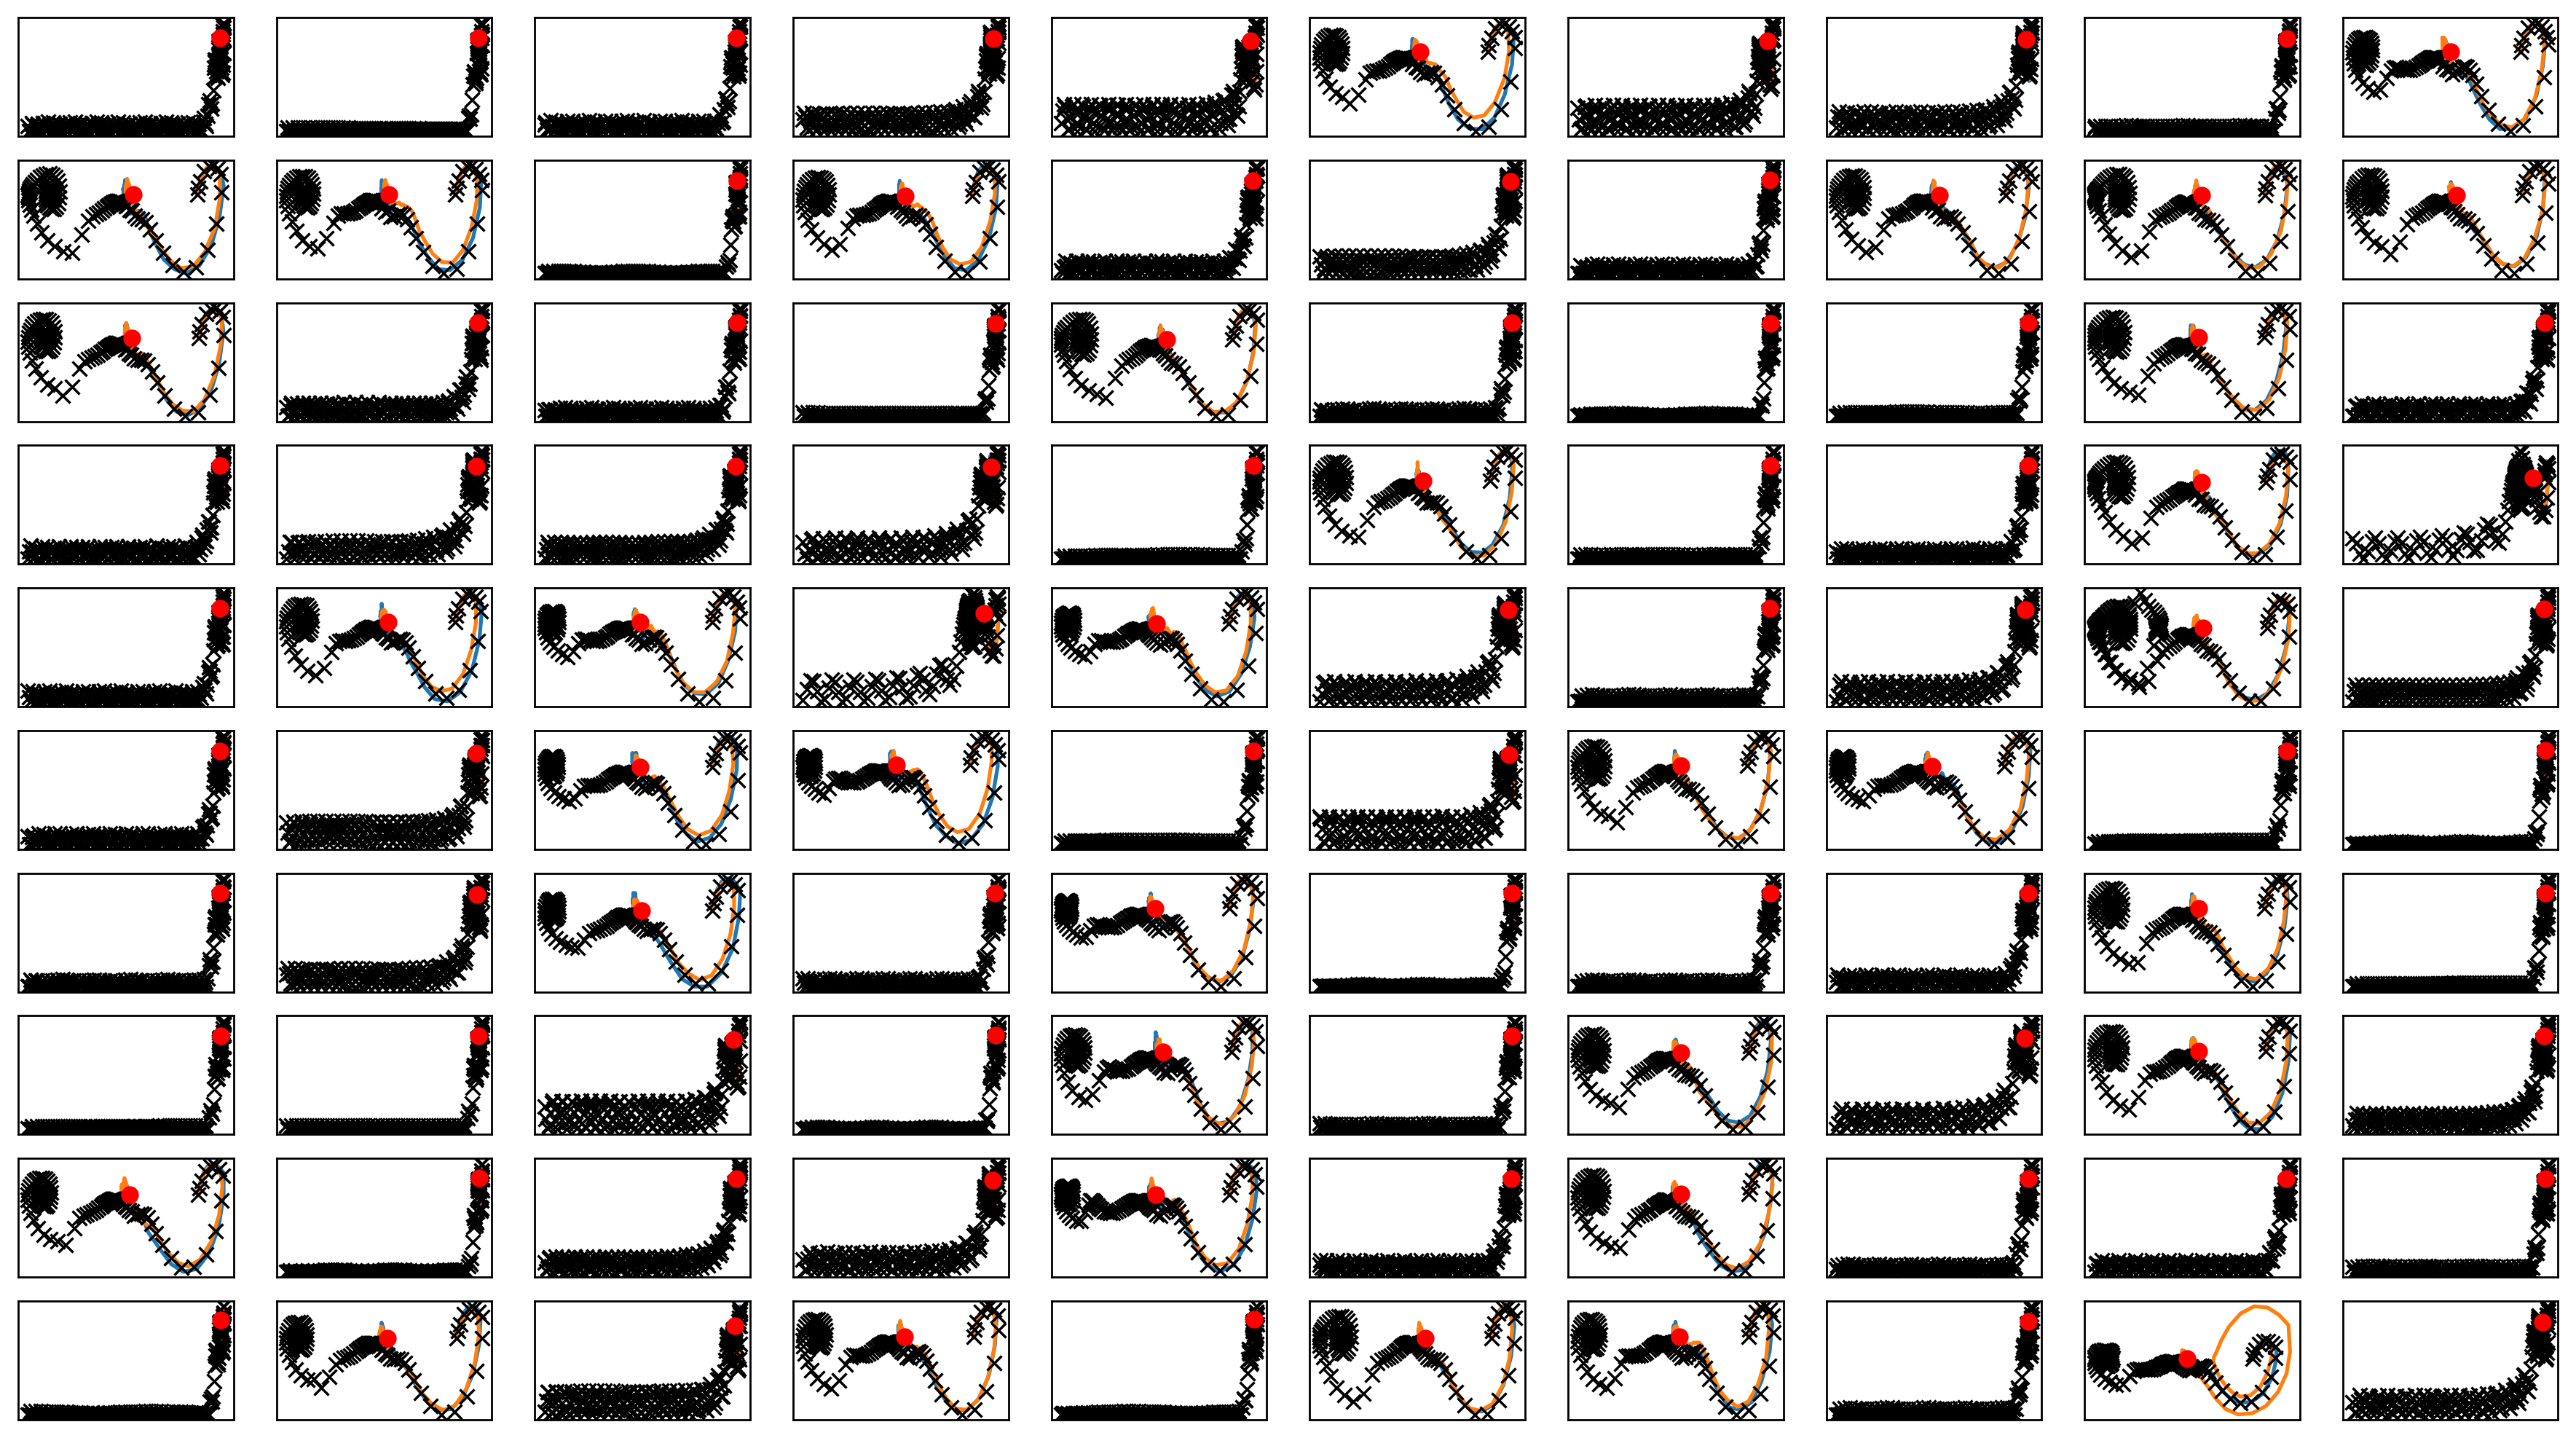

In [9]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [10]:
print(datetime.datetime.now())

2023-06-26 01:32:56.549364
